In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from IPython.display import display, HTML

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

plt.rcParams["figure.figsize"] = (20,8)

In [2]:
tmax = pd.read_csv("new_england_tmax.csv", index_col = "date", parse_dates=True)
tavg = pd.read_csv("new_england_tavg.csv", index_col = "date", parse_dates=True)
tmin = pd.read_csv("new_england_tmin.csv", index_col = "date", parse_dates=True)
prcp = pd.read_csv("new_england_prcp.csv", index_col = "date", parse_dates=True)

In [3]:
tavg

measurement
date                   
1951-01-01        -7.01
1951-01-02        -6.75
1951-01-03        -1.29
1951-01-04         4.18
1951-01-05        -0.57
...                 ...
2021-12-27        -2.83
2021-12-28        -3.98
2021-12-29        -1.90
2021-12-30        -1.52
2021-12-31         0.49

[25933 rows x 1 columns]

<AxesSubplot:xlabel='date'>

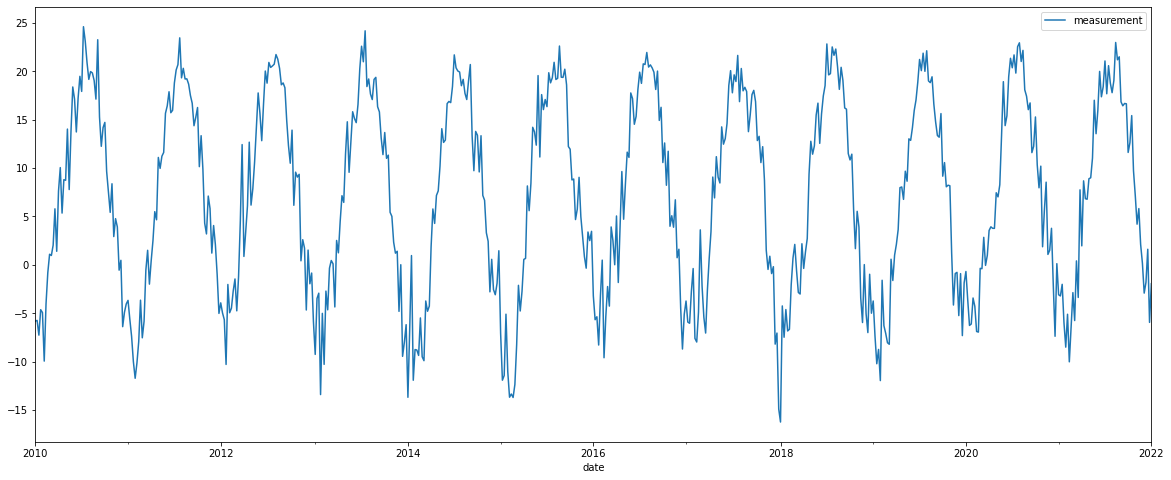

In [9]:
weekly = tavg.resample("W").mean()
weekly["2010-01-01":].plot()

In [10]:
# we use all the data up to 2015 for our model
xs = ExponentialSmoothing(weekly[:"2015-01-01"],trend='add',seasonal='add',seasonal_periods=52, freq="W")
fitted_model = xs.fit()

In [97]:
# now we forecast multiple years ahead 
start_date = len(weekly[:"2015-01-01"])
end_date = len(weekly[:"2021-01-01"])


actual = weekly["2015-01-01":"2021-01-07"]

#the benchmark will be the last few years measurements
# so we can compare our forecast to the last few years to see if there will be any improvement
benchmark = pd.DataFrame(index=actual.index)
benchmark["benchmark"] = weekly["2009-01-01":"2015-01-04"].values

#fit the model
prediction = fitted_model.predict(start=start_date, end=end_date )

comparison = pd.concat([actual, prediction, benchmark], axis=1)
comparison.columns = ["actual", "hw_predicted","benchmark"]
comparison

actual  hw_predicted  benchmark
2015-01-04  -7.065714     -8.039825  -7.165714
2015-01-11 -11.920000     -7.003885  -7.731429
2015-01-18 -11.432857     -5.754761 -15.155714
2015-01-25  -5.098571     -9.194617 -10.148571
2015-02-01 -11.024286     -7.576597 -11.661429
...               ...           ...        ...
2020-12-06   3.775714     -4.816078  -2.551429
2020-12-13  -2.045714     -4.093635  -3.088571
2020-12-20  -7.382857     -5.597598  -1.911429
2020-12-27   0.121429     -8.008554   1.457143
2021-01-03  -3.091429     -6.972614  -7.065714

[314 rows x 3 columns]

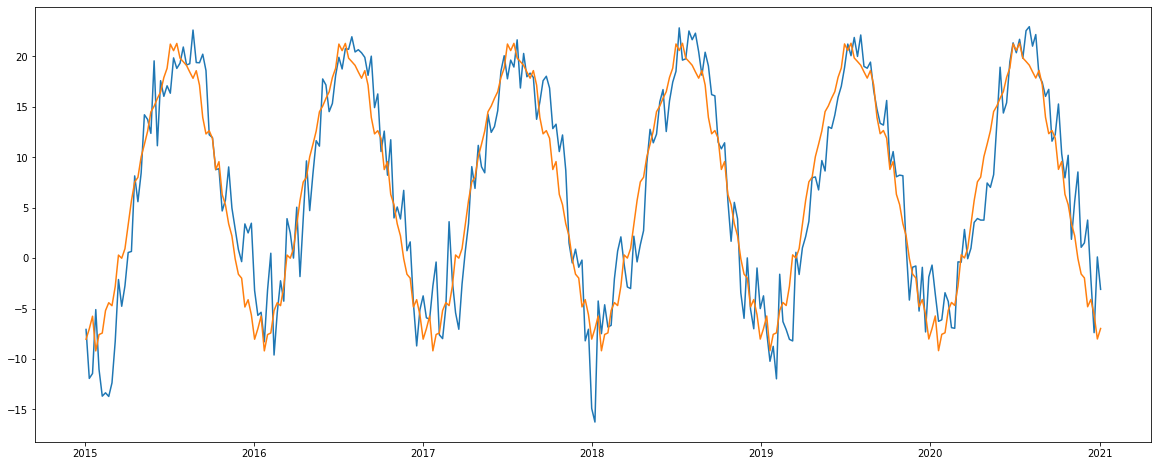

In [104]:
plt.plot(comparison.index, comparison.actual, comparison.hw_predicted)
plt.show()

In [100]:
# comparison.fillna(method="ffill", inplace=True)
mse_value = mse(comparison["actual"], comparison["hw_predicted"])
mae_value = mae(comparison["actual"], comparison["hw_predicted"])
r2   = r2_score(comparison["actual"], comparison["hw_predicted"])

mse_value, mae_value, r2

(12.125034199383414, 2.7880063550379575, 0.8810379377820186)

In [101]:
mse_value = mse(comparison["benchmark"], comparison["actual"])
mae_value = mae(comparison["benchmark"], comparison["actual"])
r2   = r2_score(comparison["benchmark"], comparison["actual"])

mse_value, mae_value, r2

(17.467448290653838, 3.1914194722474973, 0.8221311299013261)

Our model beats a naive benchmark. We should probably use simple exponential smoothing to create a benchmark based on past data and see how well our model improves on that, but we will leave that for another day.

In [96]:
sarimax_model=sm.tsa.statespace.SARIMAX(weekly["1980-01-01":"2015-01-01"],order=(1, 1, 1),seasonal_order=(1,1,1,52))
results=sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57695D+00    |proj g|=  8.87770D-02

At iterate    5    f=  2.44931D+00    |proj g|=  1.19706D-02

At iterate   10    f=  2.44707D+00    |proj g|=  7.29156D-03

At iterate   15    f=  2.44462D+00    |proj g|=  3.03946D-03

At iterate   20    f=  2.44348D+00    |proj g|=  1.42702D-02

At iterate   25    f=  2.44292D+00    |proj g|=  1.85432D-03

At iterate   30    f=  2.44289D+00    |proj g|=  3.27842D-04

At iterate   35    f=  2.44289D+00    |proj g|=  6.29032D-04

At iterate   40    f=  2.44289D+00    |proj g|=  1.27764D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final

In [102]:
comparison["sarimax"]= results.predict(start="2015-01-01", end="2021-01-01")
comparison

actual  hw_predicted  benchmark   sarimax
2015-01-04  -7.065714     -8.039825  -7.165714 -4.928564
2015-01-11 -11.920000     -7.003885  -7.731429 -6.227123
2015-01-18 -11.432857     -5.754761 -15.155714 -6.061739
2015-01-25  -5.098571     -9.194617 -10.148571 -8.388282
2015-02-01 -11.024286     -7.576597 -11.661429 -7.165674
...               ...           ...        ...       ...
2020-12-06   3.775714     -4.816078  -2.551429 -4.516615
2020-12-13  -2.045714     -4.093635  -3.088571 -3.796859
2020-12-20  -7.382857     -5.597598  -1.911429 -3.752889
2020-12-27   0.121429     -8.008554   1.457143 -6.782916
2021-01-03  -3.091429     -6.972614  -7.065714 -6.559233

[314 rows x 4 columns]

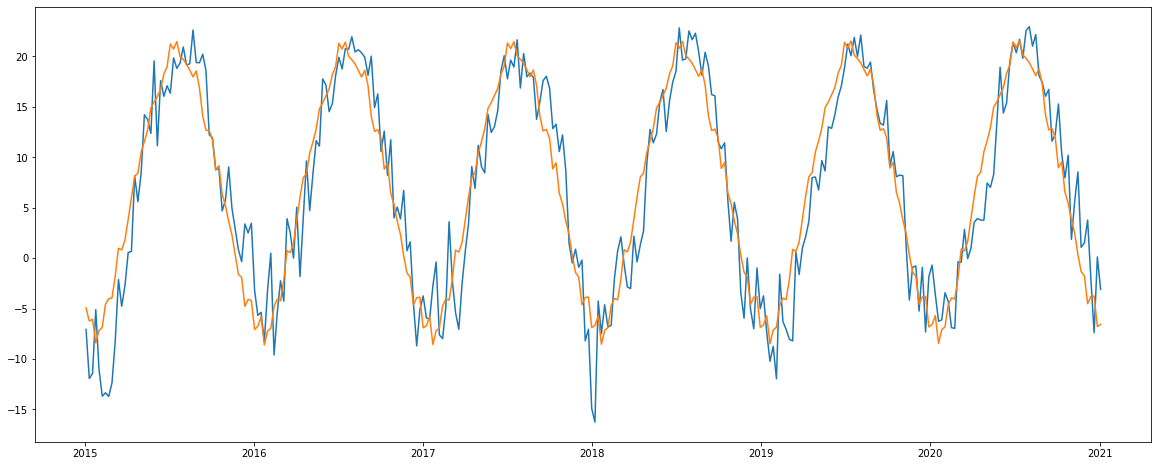

In [103]:
plt.plot(comparison.index, comparison.actual, comparison.sarimax)
plt.show()

In [105]:
mse_value = mse(comparison["actual"], comparison["sarimax"])
mae_value = mae(comparison["actual"], comparison["sarimax"])
r2   = r2_score(comparison["actual"], comparison["sarimax"])

mse_value, mae_value, r2

(12.393665973733619, 2.8254051874289936, 0.878402317186771)

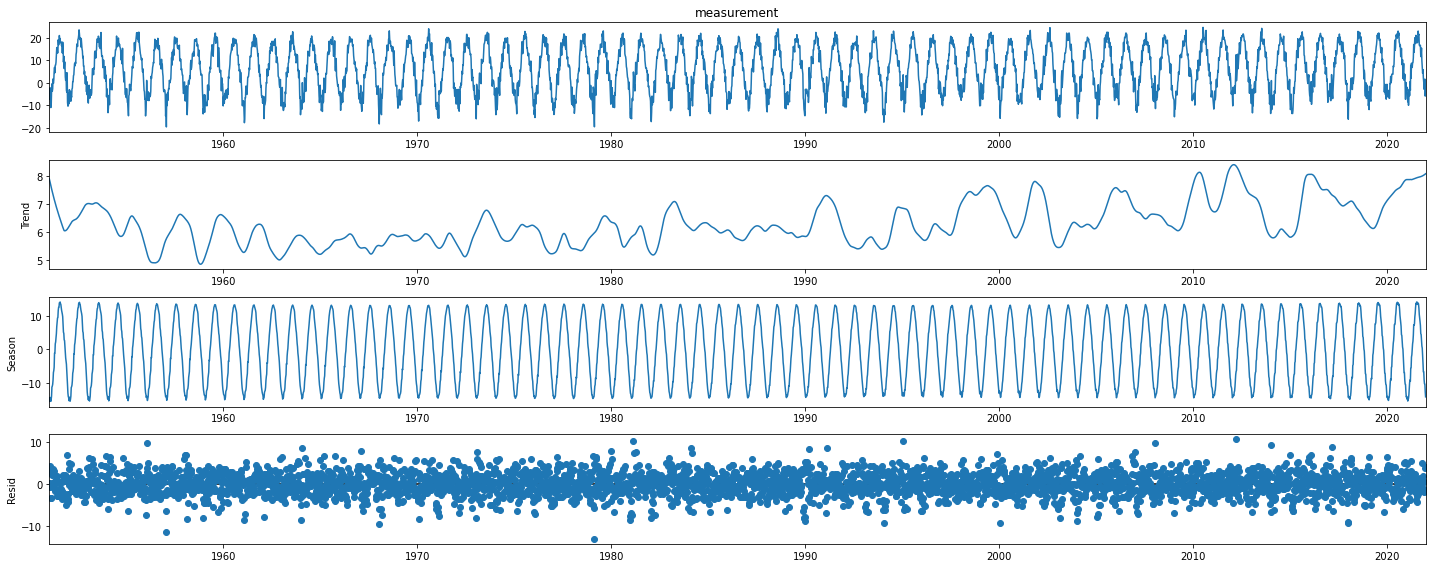

In [107]:
stl = STL(weekly["measurement"], seasonal=53)
res = stl.fit()
fig = res.plot()

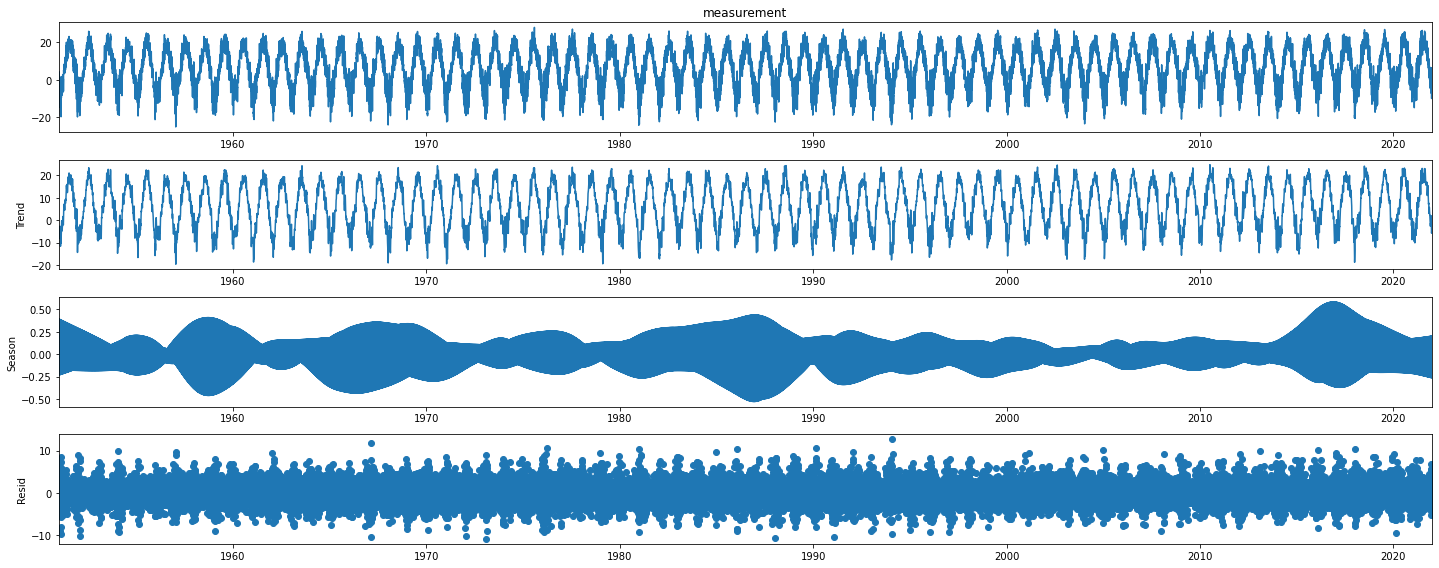

In [108]:
stl = STL(tavg["measurement"], seasonal=365)
res = stl.fit()
fig = res.plot()

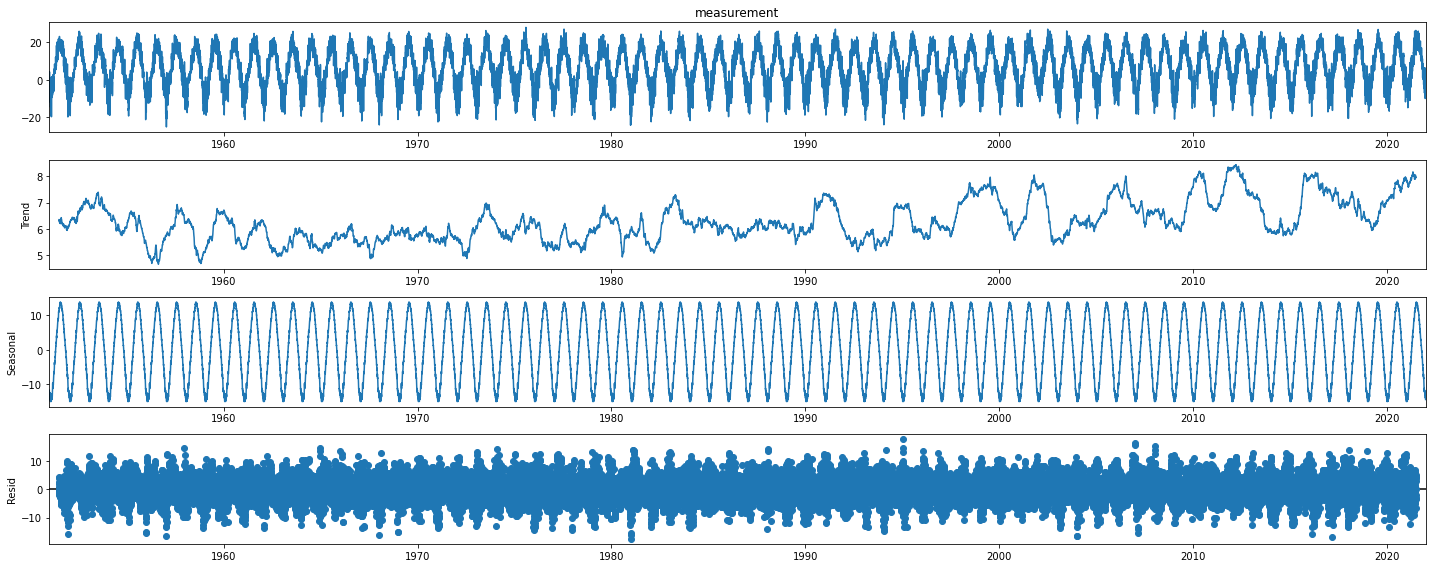

In [109]:
decomposition = sm.tsa.seasonal_decompose(tavg["measurement"], period = 365, model='additive')
fig = decomposition.plot()


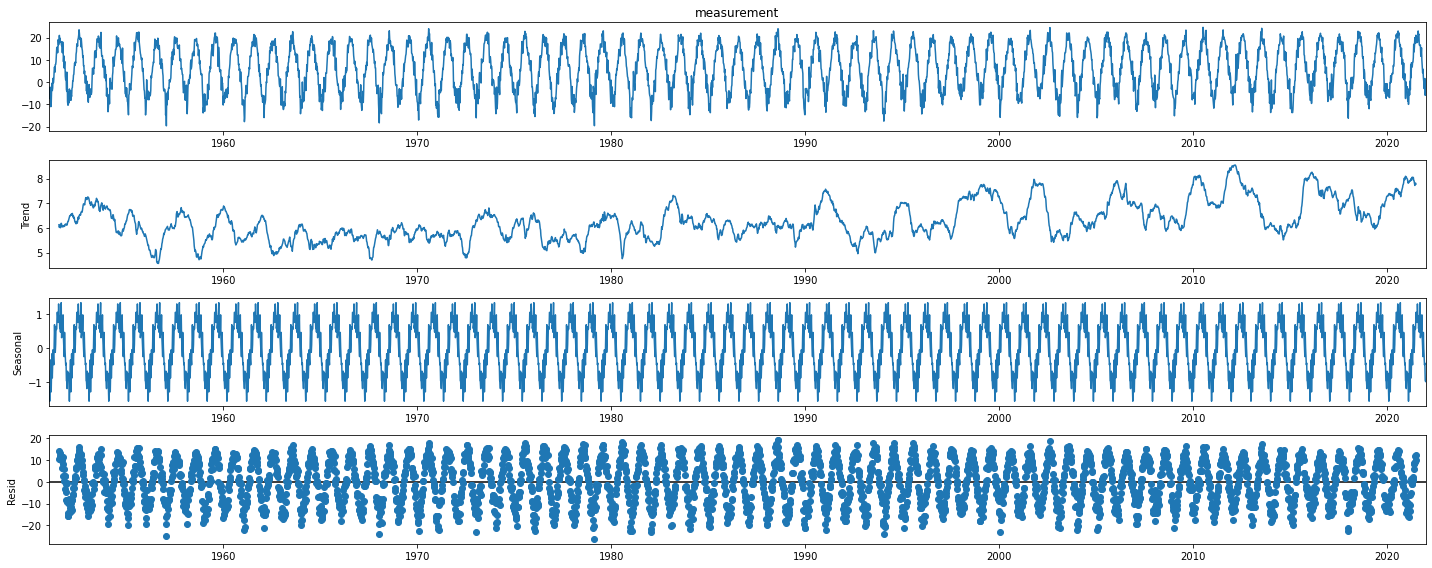

In [110]:

decomposition = sm.tsa.seasonal_decompose(weekly["measurement"], period = 53, model='additive')
fig = decomposition.plot()
